In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
from math import sqrt
%matplotlib inline

doc : <br>
https://www.programcreek.com/python/example/104025/skimage.filters.sobel <br>
https://www.kaggle.com/outputlogic/exploratory-image-analysis <br>
https://www.kaggle.com/inversion/run-length-decoding-quick-start <br>
https://www.kaggle.com/meaninglesslives/airbus-ship-detection-data-visualization <br>

### plot random image

In [2]:
df = pd.read_csv("all/train_ship_segmentations.csv", header=0)

In [3]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [4]:
df['ship_count'] = df.groupby('ImageId')['ImageId'].transform('count')

In [5]:
df['ship_count'].describe()

count    131030.000000
mean          2.223766
std           2.711032
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          15.000000
Name: ship_count, dtype: float64

In [6]:
df.loc[df['EncodedPixels'].isnull(),'ship_count'] = 0

In [7]:
df_unique = df.drop_duplicates("ImageId")

Frequence image ship / no ship

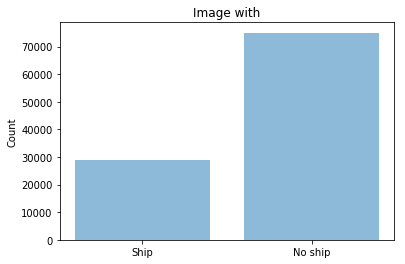

In [8]:
objects = ('Ship', 'No ship')
y_pos = np.arange(len(objects))
ships = [df_unique[df_unique["ship_count"] > 0]["ImageId"].count(),df_unique[df_unique["ship_count"] == 0]["ImageId"].count()]
 
plt.bar(y_pos, ships, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Image with')
plt.show()

Frequence number ship

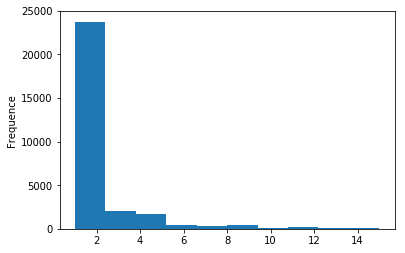

In [9]:
plt.hist(df_unique[df_unique["ship_count"] > 0]["ship_count"])
plt.ylabel('Frequence')
plt.show()

display random image

In [165]:
np.random.seed(42)

def random_display_image(datas, title):
    def display_matrix(X, title, row=4):
        nimgs = np.array_split(imgs, 4)
        X_full = np.array([])
        for img in nimgs:
            X_data = np.array([])
            for x in img:
                if X_data.any():
                    X_data = np.concatenate((X_data, x), axis=1)
                else:
                    X_data = x

            if X_full.any():
                X_full = np.concatenate((X_full, X_data), axis=0)
            else:
                X_full = X_data
    
        fig = plt.figure(figsize=(14, 10))
        plt.imshow(X_full)
        plt.title(title)
        plt.axis("off")
        
    
    nbImg = 32
    train_id = list(datas)
    np.random.shuffle(train_id)
    imgs = []
    for i in range(nbImg):
        n = train_id[i]
        img = Image.open('all/train/'+n).convert("RGB")
        draw = ImageDraw.Draw(img)
        fnt = ImageFont.truetype("/Library/Fonts/Comic Sans MS.ttf", 72)
        draw.text((10, 650), n, (255,0,0), font=fnt)
        img = np.array(img)
        imgs.append(img)

    imgs = np.array(imgs)
    display_matrix(imgs, title)

Training Set Ship Count 0 i.e. no ship

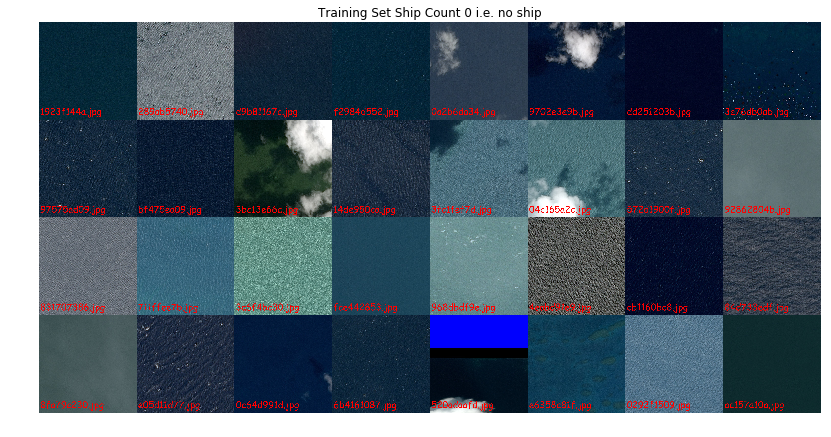

In [169]:
noship = df_unique[df_unique["ship_count"] == 0]
random_display_image(noship["ImageId"], "Training Set Ship Count 0 i.e. no ship")

Training Set Ship Count 3 

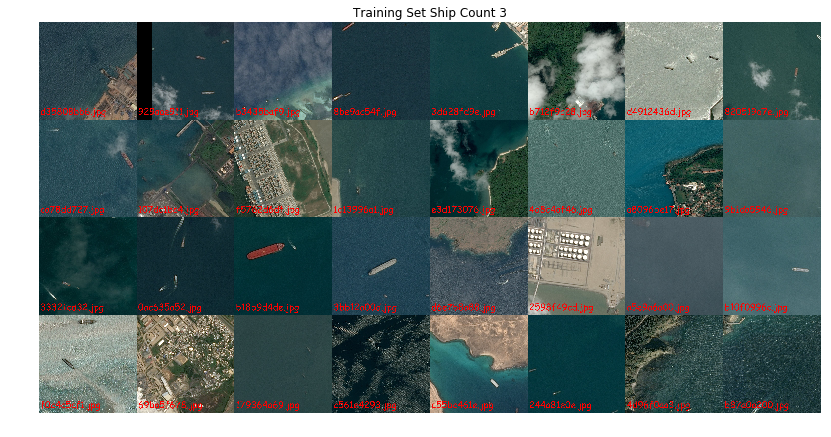

In [175]:
noship = df_unique[df_unique["ship_count"] == 3]
random_display_image(noship["ImageId"], "Training Set Ship Count 3")

### Color ship

In [278]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def mask_overlay(image, mask):
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.75, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [ ]:
# random datas
ships = df_unique[df_unique["ship_count"] > 0]
index_ships = list(ships.index)
np.random.shuffle(index_ships)
ships = ships.loc[index_ships]

In [272]:
img = cv2.imread('all/train/0528f0737.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [273]:
all_masks = np.zeros((768, 768))
img_masks = df.loc[df['ImageId'] == "0528f0737.jpg"]["EncodedPixels"].tolist()
for mask in img_masks:
    all_masks += rle_decode(mask)
all_masks = np.expand_dims(all_masks,axis=2) # ajoute une "array" a l'array ex : (768x768) => (768x768x1)
all_masks = np.repeat(all_masks,3,axis=2).astype('uint8')*255 # repete tout 3, augmente "dimension" : ex : (768x768x1) => (768x768x3)

In [276]:
img_masked = mask_overlay(img, all_masks)

(-0.5, 767.5, 767.5, -0.5)

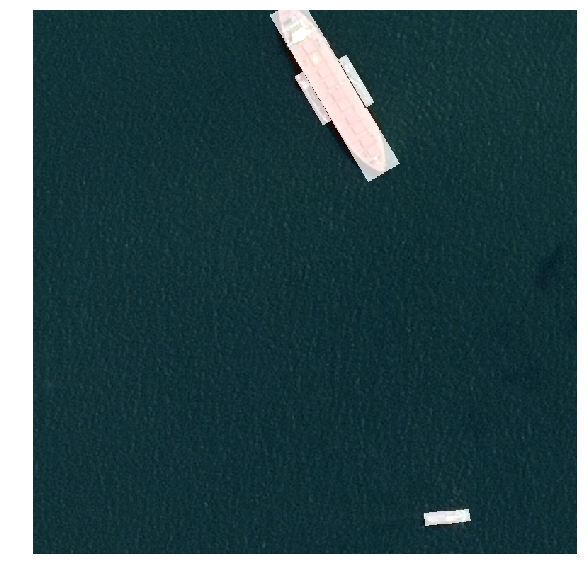

In [277]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(img_masked)
plt.axis("off")

#### data augmentation - extract feature

In [322]:
from skimage import exposure, util, filters
from skimage.feature import canny
from skimage.filters import scharr
from skimage.filters import gaussian,laplace
from skimage.color import rgb2gray

/Users/yannis/anaconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/Users/yannis/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/Users/yannis/anaconda3/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


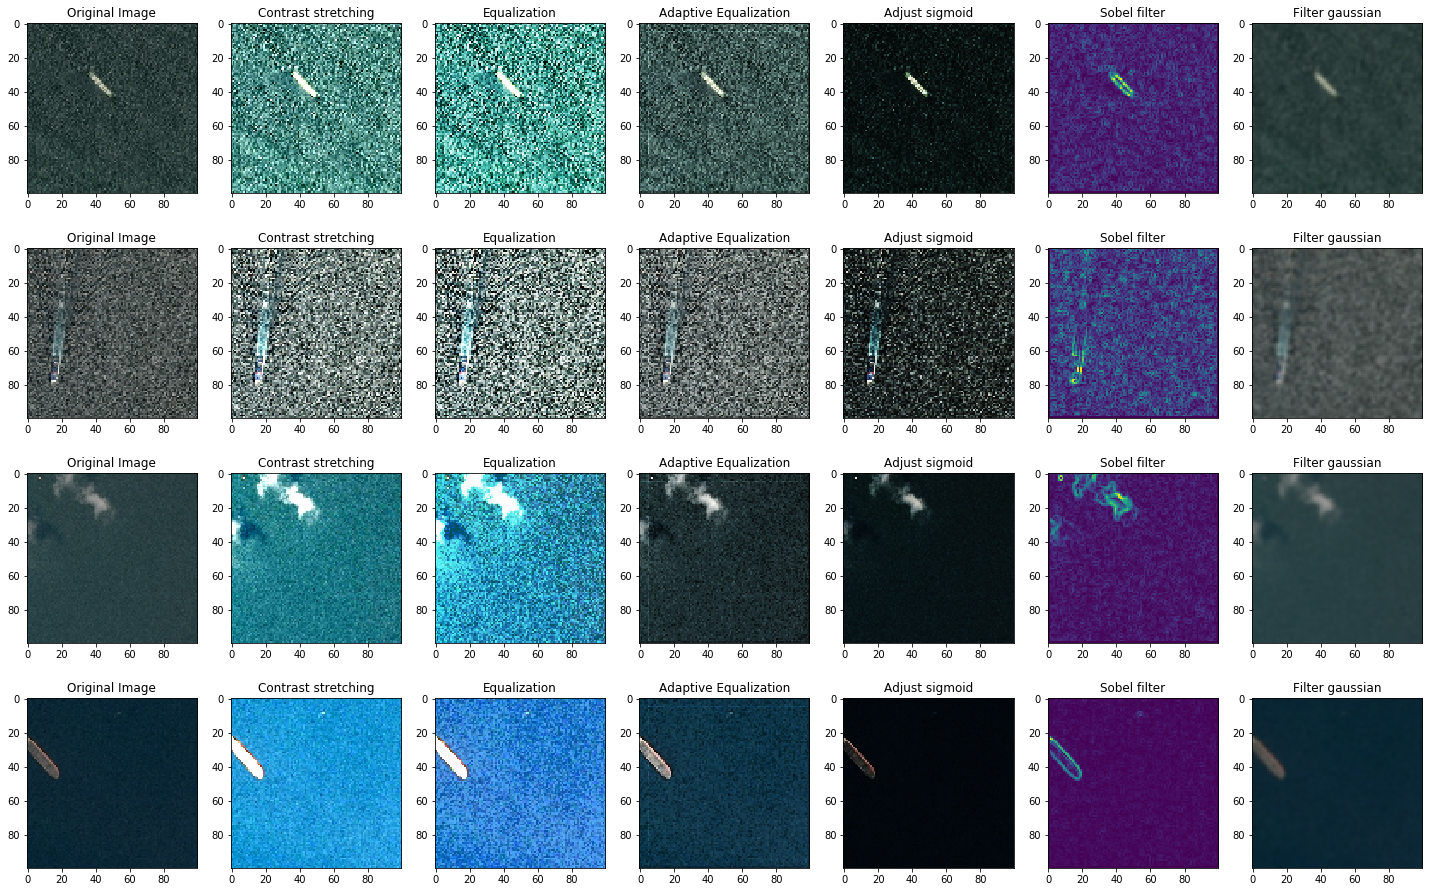

In [382]:
plt.figure(figsize=(25,20))
#plt.subplots_adjust(bottom=0.1, top=0.1) 

for x in range(1,5):
    img = cv2.imread('all/train/'+ships["ImageId"].tolist()[x])
    resized_image = cv2.resize(img, (100, 100)) 
    img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
     
    # Original
    plt.subplot(5,7,x*7-6)
    plt.imshow(img)
    plt.title('Original Image')

    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    plt.subplot(5,7,x*7-5)
    plt.imshow(img_rescale)
    plt.title('Contrast stretching')

    # Equalization
    img_eq = exposure.equalize_hist(img)
    plt.subplot(5,7,x*7-4)
    plt.imshow(img_eq)
    plt.title('Equalization')

    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img)
    plt.subplot(5,7,x*7-3)
    plt.imshow(img_adapteq)
    plt.title('Adaptive Equalization')

    # Adjust sigmoid
    img_dist = exposure.adjust_sigmoid(img)
    plt.subplot(5,7,x*7-2)
    plt.imshow(img_dist)
    plt.title('Adjust sigmoid')

    # Sobel
    edges = filters.sobel(rgb2gray(img))
    plt.subplot(5,7,x*7-1)
    plt.imshow(edges)
    plt.title('Sobel filter')

    # Filter gaussian
    gass = filters.gaussian(img)
    plt.subplot(5,7,x*7)
    plt.imshow(gass)
    plt.title('Filter gaussian')


#### Create dataset

In [9]:
labels = []
train = []
i = 0
for index, row in df_unique.iterrows():
    
    img = cv2.imread('all/train/'+row["ImageId"])
    
    #train.append(img)
    continue
    if row["ship_count"] == 0:
        labels.append(0)
    else:
        labels.append(1)
    
    if i == 10000:
        break
    
    i += 1

(10001, 768, 768, 3)

(10001,)